# Training data and satellite data

Sometimes its useful to extract mean pixel values from training data prior to running a classifier on your data to try and see how similar your labelled training datasets are. 

In this notebook I will be combining GeoPandas, Rasterio and a bit of plotting using matplotlib to do this
<br>
There is some considerable scope to improve this workflow. I'm using only 3 band data on very small training datasets, but hopefuly you can see the potential to extend

### Common imports

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import shapely
import fiona
import rasterio
from rasterio import plot
from rasterio.mask import mask

### Load in some training data (a shapefile with an id and class) - all data is in the same projection

In [2]:
training_data = gpd.read_file(r"training.shp")
print(training_data.head())

   id      class                                           geometry
0   1      Water  POLYGON ((647905.136 5629875.093, 648156.469 5...
1   2      Field  POLYGON ((650678.179 5629732.671, 650912.757 5...
2   3  BareEarth  POLYGON ((651128.485 5627533.505, 651224.829 5...
3   3  BareEarth  POLYGON ((650942.079 5627208.866, 651027.951 5...
4   2      Field  POLYGON ((652427.040 5626062.159, 652533.856 5...


### Plot it based on the class field

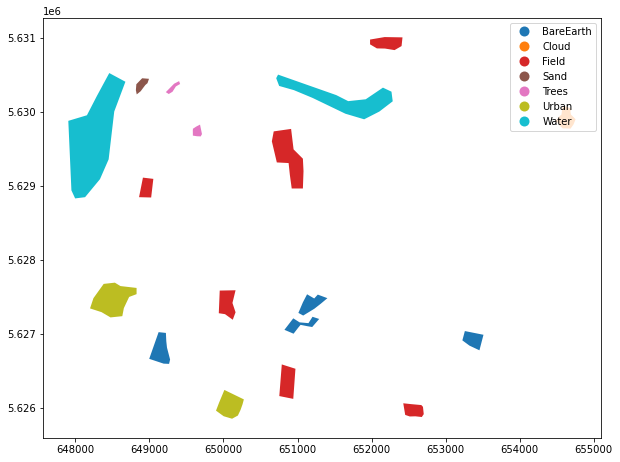

In [3]:
training_data.plot(column='class', cmap=None, legend=True, figsize=(10, 10))

### Now open the corresponding satellite image and plot it

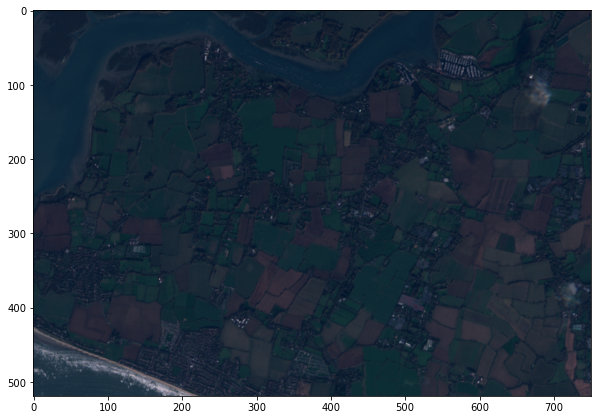

(3, 519, 751)

In [4]:
datain = r"south_coast.tif"
raster = rasterio.open(datain)
arr = raster.read()
plt.figure(figsize=(10,10))
plot.show(rasterio.plot.adjust_band(arr))
arr.shape

### Overlay both datasets

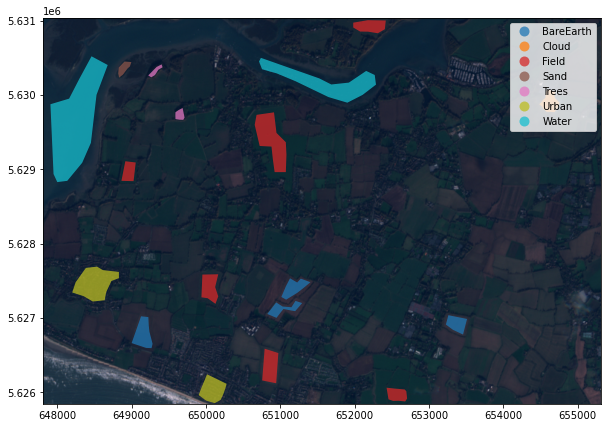

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(rasterio.plot.adjust_band(arr), transform=raster.transform, ax=ax)
training_data.plot(ax=ax, column='class', cmap=None, legend=True, alpha=0.75)

I want to extract all the pixels (from rgb data) from the shapefiles used as a mask. Two ways to do this, firstly using fiona

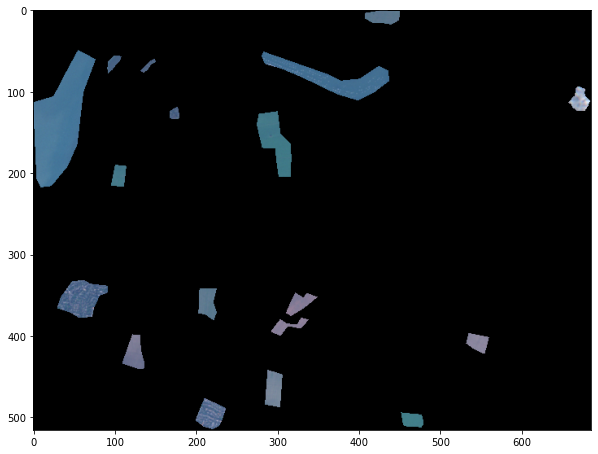

In [6]:
with fiona.open("training.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

out_image, out_transform = mask(raster, shapes, crop=True)
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(rasterio.plot.adjust_band(out_image))

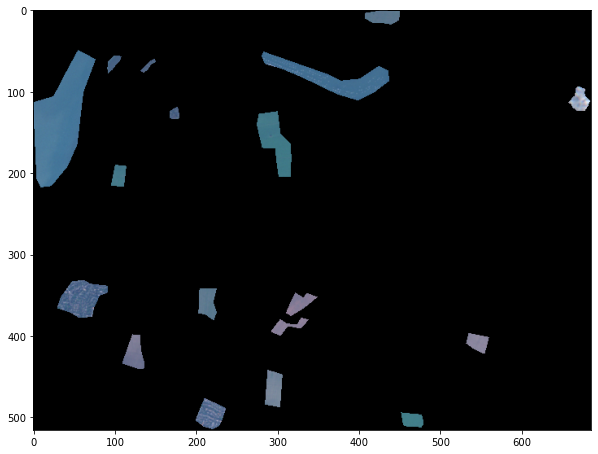

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(rasterio.plot.adjust_band(out_image))

or using shapely - I think I prefer this way, but either gets you there

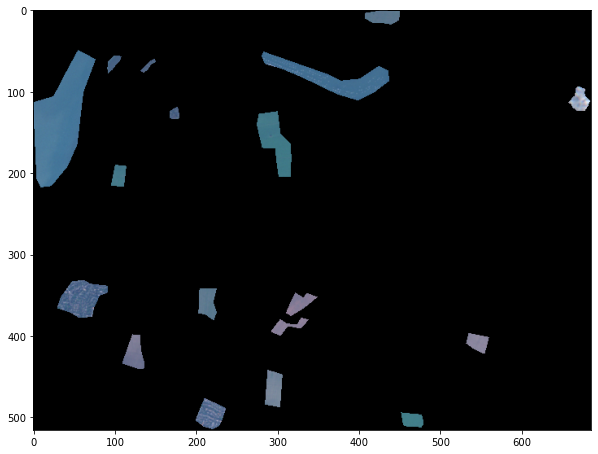

In [8]:
geom = [shapely.geometry.mapping(training_data)["features"][i]["geometry"] for i in range(0,len(training_data))]

out_image, out_transform = mask(raster, geom, crop=True)
fig, ax = plt.subplots(figsize=(10, 10))
plot.show(rasterio.plot.adjust_band(out_image))

### Now extract the values on a feature by feature basis and get the red, green and blue and print

In [9]:
for count, value in enumerate(geom):
    out_image, out_transform = mask(raster, [value], crop=True)
    red = out_image[0,:,:].mean()
    green = out_image[1,:,:].mean()
    blue = out_image[2,:,:].mean()
    print(f"{training_data.iloc[count]['class']}: {red}, {green}, {blue}")

Water: 347.2429110105581, 570.8265460030166, 732.142383107089
Field: 322.9537037037037, 595.5836139169472, 670.6175645342312
BareEarth: 575.673275862069, 533.7560344827587, 651.5491379310345
BareEarth: 429.76128472222223, 398.7057291666667, 479.7708333333333
Field: 456.66424682395643, 874.0199637023593, 952.8166969147005
Urban: 509.66346153846155, 617.0173076923077, 803.4378205128205
Cloud: 854.008064516129, 910.2085253456221, 1019.0921658986175
Sand: 307.9588100686499, 425.52402745995425, 563.7665903890161
Trees: 467.5656108597285, 597.4751131221719, 794.8054298642534
Trees: 193.95488721804512, 245.14786967418547, 322.328320802005
BareEarth: 632.3832288401254, 646.1669278996865, 797.2452978056426
Field: 628.3308589607635, 823.1198303287381, 971.2184517497349
Field: 821.4128787878788, 930.529356060606, 1068.3910984848485
Water: 190.1728545343883, 311.4396429296003, 409.89784946236557
Urban: 447.7516276041667, 578.8880208333334, 769.9345703125
BareEarth: 759.0893997445721, 738.464878671

### Extract the values into an array instead and then join to your geodataframe
At this point you can simplify the above code and save (not done here) to a new shapefile

In [10]:
lsmean = []
for count, value in enumerate(geom):
    out_image, out_transform = mask(raster, [value], crop=True)
    mean_img = out_image.mean(axis=(1,2))
    lsmean.append(mean_img)
    
df = pd.DataFrame(np.vstack(lsmean))
df.rename({0: 'mean_band1', 1: 'mean_band2', 2: 'mean_band3'}, axis=1, inplace=True)
df_mean = training_data.join(df)
print(df_mean.head())


   id      class                                           geometry  \
0   1      Water  POLYGON ((647905.136 5629875.093, 648156.469 5...   
1   2      Field  POLYGON ((650678.179 5629732.671, 650912.757 5...   
2   3  BareEarth  POLYGON ((651128.485 5627533.505, 651224.829 5...   
3   3  BareEarth  POLYGON ((650942.079 5627208.866, 651027.951 5...   
4   2      Field  POLYGON ((652427.040 5626062.159, 652533.856 5...   

   mean_band1  mean_band2  mean_band3  
0  347.242911  570.826546  732.142383  
1  322.953704  595.583614  670.617565  
2  575.673276  533.756034  651.549138  
3  429.761285  398.705729  479.770833  
4  456.664247  874.019964  952.816697  


# Transpose the dataframe to get ready to plot

In [11]:
df_mean = pd.DataFrame(df_mean.drop(columns=['geometry', 'id']))
df_mean = df_mean.set_index('class').T

print(df_mean.head())

class            Water       Field   BareEarth   BareEarth       Field  \
mean_band1  347.242911  322.953704  575.673276  429.761285  456.664247   
mean_band2  570.826546  595.583614  533.756034  398.705729  874.019964   
mean_band3  732.142383  670.617565  651.549138  479.770833  952.816697   

class            Urban        Cloud        Sand       Trees       Trees  \
mean_band1  509.663462   854.008065  307.958810  467.565611  193.954887   
mean_band2  617.017308   910.208525  425.524027  597.475113  245.147870   
mean_band3  803.437821  1019.092166  563.766590  794.805430  322.328321   

class        BareEarth       Field        Field       Water       Urban  \
mean_band1  632.383229  628.330859   821.412879  190.172855  447.751628   
mean_band2  646.166928  823.119830   930.529356  311.439643  578.888021   
mean_band3  797.245298  971.218452  1068.391098  409.897849  769.934570   

class        BareEarth       Field       Field  
mean_band1  759.089400  627.217284  451.366071  
mea

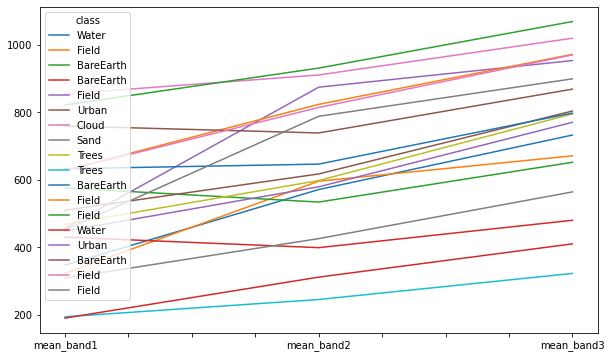

In [12]:
lines = df_mean.plot(figsize=(10,6), legend = True)

# Same as above but this time I am getting 1 graph per class category and plotting

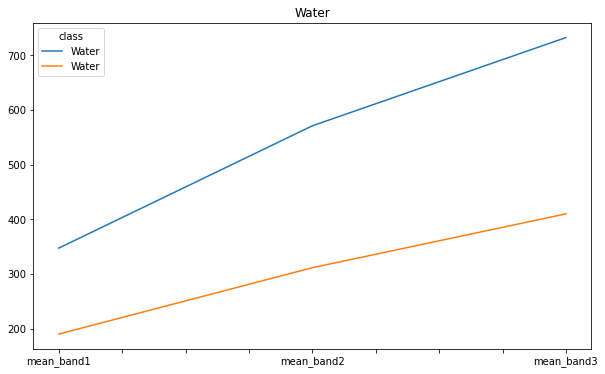

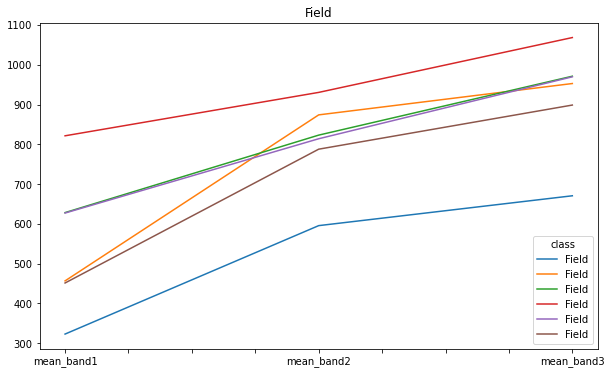

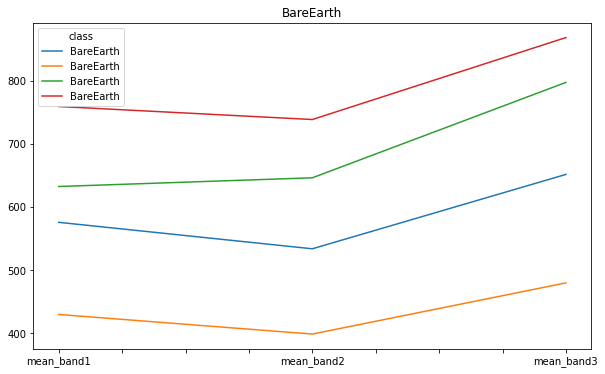

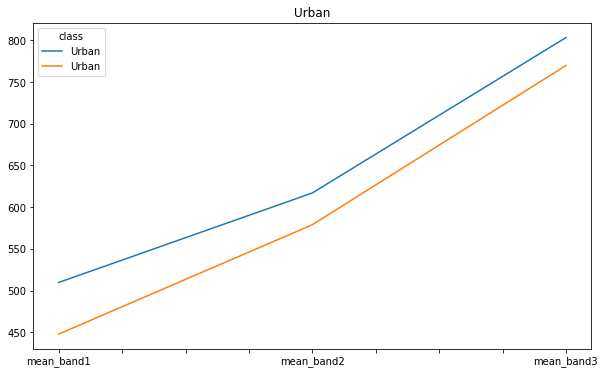

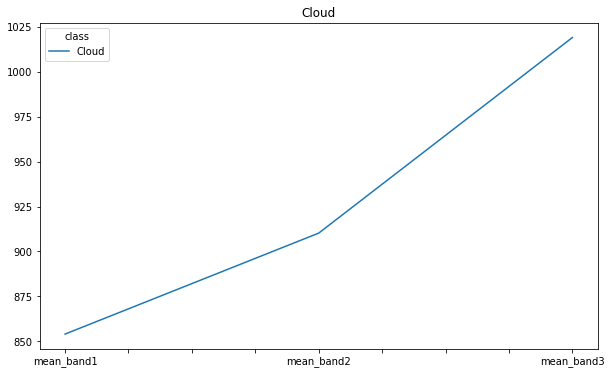

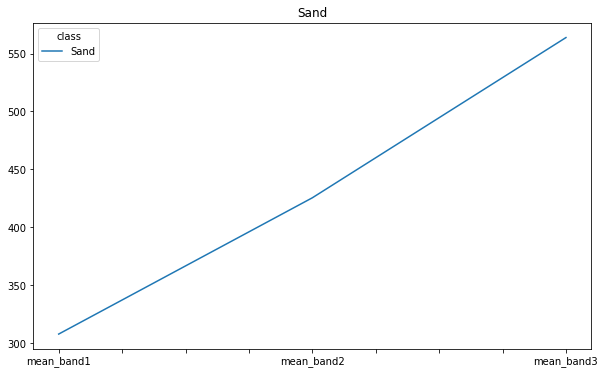

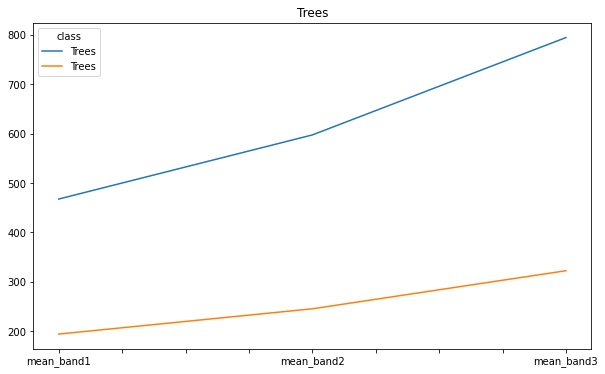

In [13]:
lsmean = []
for count, value in enumerate(geom):
    out_image, out_transform = mask(raster, [value], crop=True)
    mean_img = out_image.mean(axis=(1,2))
    lsmean.append(mean_img)

    
df = pd.DataFrame(np.vstack(lsmean))
df.rename({0: 'mean_band1', 1: 'mean_band2', 2: 'mean_band3'}, axis=1, inplace=True)
df_mean = training_data.join(df)

cat = list(df_mean['class'].unique())

def plot_training(cat, df_in):
    df_cat = df_in[df_in['class'] == cat]
    df = pd.DataFrame(df_cat.drop(columns=['geometry', 'id']))
    df = df.set_index('class').T
    title = cat
    lines = df.plot(figsize=(10,6), legend = True, title = title)
    return None

for category in cat:
    plot_training(category, df_mean)





    